This project aims to predict students’ academic performance based on their background attributes using various machine learning models, including Linear Regression, Random Forest, Multi-Layer Perceptron (MLP), XGBoost, and a Voting ensemble. The work is divided into two primary stages: Exploratory Data Analysis (EDA) and Model Development.

## Exploratory Data Analysis
*   **Programming Concepts**<br>
    The `prepare_data` class is designed for managing and preprocessing educational datasets in preparation for machine learning tasks. It handles column categorization, data cleaning, encoding, statistical analysis, and visualization.
*   **Main Discoveries**
    1. There are no duplicated or missing data in the dataset.
    2. Students who spend more time studying and less time hanging out with friends tend to have higher average G3 grades, as shown in Figure 2.
    3. Statistical analysis using Kernel Density Estimation (KDE), ANOVA, and Tukey HSD tests indicates that **parental background, student aspirations, and living environment** significantly affect students' final grades (p-value < 0.05), as shown in Figure 3. Key insights include:
    
      - Parental Education Level: Students whose parents have the lowest education level (rank 1) score significantly lower in G3 compared to those whose parents have the highest level (rank 4).
      - Parental Occupation: Students whose mothers are homemakers ("at_home") tend to perform worse than those whose mothers work in the health sector.
      - Student Intentions: Those planning to pursue higher education generally perform better.
      - Living Environment: Urban-living students typically achieve higher average G3 grades than their rural counterparts.

    4. As shown in Figure 4, early academic performance (G1 and G2) is highly predictive of final grades (G3). Conversely, students with more past academic failures tend to perform worse.

*   **Data Preprocessing** <br>
    Based on the above analysis, the data does not contain any counterintuitive patterns and is complete. Therefore, only the following two types of variables are transformed:
    1. Nominal Variables: One-Hot Encoding was used.
    2. Numerical Variables: Variables with high skewness (specifically failures and absences) were scaled using `RobustScaler()`. All other numerical features were standardized using `StandardScaler()`.

## Model Training
To compare the performance of four regression models and a voting ensemble for predicting a continuous variable, using GridSearchCV for hyperparameter tuning and mean squared error (MSE) as the evaluation metric.

**Cross-Validation Results** <br>
Using 5-fold cross-validation:
1. XGBRegressor achieved the lowest mean test MSE (≈ 2.01), indicating the best generalization performance.
2. The Voting Ensemble combines the strengths of individual models, but in this case, it did not outperform XGBRegressor alone.

**Final Model Evaluation** <br>
Based on cross-validation results, XGBRegressor was selected as the final model. It demonstrated strong predictive accuracy on the test set, with an MSE of 4.04, a Root Mean Squared Error (RMSE) of 2.01, and an R² score of 0.80, indicating a good model fit.


In [ ]:
class prepare_data:
  def __init__(self, data):
    self.data = data
    self.columns_type = {'nominal_var':["school","sex","address","famsize","Pstatus",
                                        "Medu", "Fedu", "Mjob", "Fjob","reason",
                                        "guardian","schoolsup","famsup","paid","activities",
                                        "nursery","higher","internet","romantic"],
                         'order_var':["famrel", "freetime", "goout", "Dalc", "Walc",
                                      "health","traveltime", "studytime"],
                         'numerical_var':["age", "failures", "absences","G1","G2"],
                         'target_var':['G3']}

    self.save_path = '/content/gdrive/MyDrive/....'

  def clearning_nominal_variable(self):
    data = self.data.copy()
    noorder_variables = self.columns_type['nominal_var']

    for col in noorder_variables:
      encoded_data = pd.get_dummies(data[col], prefix=col + '_c', drop_first=True, dtype=int)
      data = pd.concat([data, encoded_data], axis=1)

    data_c = data.drop(columns = noorder_variables)

    return data_c

  def clearning_numerical_var(self,traingdataset, testdataset):
    columns = self.columns_type["numerical_var"]
    approx_sym = ["age","G1","G2"]

    for col in columns:
      if columns in approx_sym:
        scaler = StandardScaler()
        traingdataset[col] = scaler.fit_transform(traingdataset[[col]])
        testdataset[col] = scaler.transform(testdataset[[col]])

      else :
        scaler = RobustScaler()
        traingdataset[col] = scaler.fit_transform(traingdataset[[col]])
        testdataset[col] = scaler.transform(testdataset[[col]])

    return traingdataset, testdataset

  def skew(self, col):
    skewness_value = stats.skew(self.data[col])

    return skewness_value

  def plot_category_cols(self):
    nominal_vars = self.columns_type['nominal_var']
    n_cols = 3
    n_rows = math.ceil(len(nominal_vars) / n_cols)

    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, n_rows * 5))
    axes = axes.flatten()

    for i, col in enumerate(nominal_vars):
        categories = self.data[col].unique()
        plot_data = []
        group_labels = []
        for category in categories:
            category_data = self.data[self.data[col] == category]['G3']
            plot_data.append(category_data)
            group_labels.extend([category] * len(category_data))

        if len(plot_data) > 1:
          p_value = f_oneway(*plot_data).pvalue
          title = f'Distribution of G3 by {col}\n ANOVA p-value = {p_value:.4f}'

          if p_value < 0.05:
              scores = pd.concat(plot_data)
              tukey = pairwise_tukeyhsd(endog=scores, groups=group_labels, alpha=0.05)
              print(f"\nTukey HSD test for {col}:")
              print(tukey)

        else:
          title = f'Distribution of G3 by {col}\n (ANOVA and Tukey tests not applicable with one category)'

        ax = axes[i]
        for j, category_data in enumerate(plot_data):
            sns.kdeplot(category_data, label=f'{col}: {categories[j]}', fill=True, ax=ax)

        ax.set_title(title)
        ax.set_xlabel('G3')
        ax.set_ylabel('Density')
        ax.legend(title=col)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle('Figure 3. Distribution of G3 by Categorical Variables', y=1.02, fontsize=16)
    plt.tight_layout()
    plt.show()
    fig.savefig(self.save_path+'category_variable.png')

  def plot_historgam(self):
    plot_cols = self.columns_type["numerical_var"]+self.columns_type["target_var"]
    n_cols = 3
    n_rows = math.ceil(len(plot_cols)/n_cols)
    plt.figure(figsize=(18, n_rows*5))

    for i, col in enumerate(plot_cols):
      skew = self.data[col].skew()
      temp_df = self.data[col]

      plt.subplot(n_rows, n_cols, i+1)
      plt.hist(temp_df, density=True, alpha=0.5, color='#87CEEB')
      plt.xlabel(col)
      plt.ylabel("Density")
      plt.title(col)
      plt.text(0.5, -0.15, f"Skewness: {skew:.2f}", ha='center', transform=plt.gca().transAxes, fontsize=10, fontstyle="italic")
      plt.grid(False)

    plt.suptitle('Figure 1. Histogram of Numerical Variables', y=1.02, fontsize=16)
    plt.tight_layout()
    plt.show()
    plt.savefig(self.save_path+'numerical_variable_histogram.png')

  def plot_boxplot(self):
    columns_to_plot = self.columns_type["order_var"]

    n_cols = 3
    n_rows = math.ceil(len(columns_to_plot) / n_cols)

    plt.figure(figsize=(18, n_rows * 5))
    for i, col in enumerate(columns_to_plot):
      plt.subplot(n_rows, n_cols, i+1)
      sns.boxplot(x=self.data[col], y=self.data['G3'], color='#87CEEB')
      plt.title(f"Boxplot of G3 by {col}")
      plt.xlabel(col)
      plt.ylabel("G3")

    plt.suptitle('Figure 2. Boxplot of Order Variables', y=1.02, fontsize=16)
    plt.tight_layout()
    plt.show()
    plt.savefig(self.save_path+'numerical_variable_boxplot.png')


  def plot_cor_matrix(self):

    plot_cols = self.columns_type["numerical_var"]+self.columns_type["target_var"]
    corr_matrix = self.data[plot_cols].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Figure 4. Correlation Matrix")
    plt.show()
    plt.savefig(self.save_path+'correlation_matrix.png')

  def summary(self):
    d_n = 'Its not have duplicated data.' if self.data.duplicated().sum() == 0 else 'Its have duplicated data.'
    missing_n = 'Its not have missing data.' if self.data.isna().any().any() == False else 'Its have missing data.'

    def format_numbers(x):
        if isinstance(x, (int, float)):
            return f'{x:.2f}'
        else:
            return x

    result_text = f'This dataset have the number of {self.data.shape[0]} data and {self.data.shape[1]} columns.{d_n} {missing_n}\n\n'+ \
      f'-statistics-\n\n'+ \
      f'numerical columns\n\n'+ \
      f'{self.data[self.columns_type["numerical_var"]].describe().to_string()}\n\n' + \
      f'order columns\n\n'+ \
      f'{self.data[self.columns_type["order_var"]].describe().to_string() }\n\n'+ \
      f'nominal columns\n\n'+ \
      f'{self.data[self.columns_type["nominal_var"]].describe(include="object").to_string() }\n\n'+ \
      '\n'+ \
      f'Lets us deep understand {self.columns_type["target_var"]} variable which is our goal variable...\n\n'+ \
      f'{self.data[self.columns_type["target_var"]].describe().to_string() }'

    print(result_text)

In [ ]:

import kagglehub
from google.colab import drive
drive.mount('/content/gdrive')

# data management
import math
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.preprocessing import RobustScaler, StandardScaler
import scipy.stats as stats
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import seaborn as sns

# model training
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor

# evaluation model
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

# other setting
pd.set_option("display.max_rows", 10)
pd.set_option("display.max_columns", 10)

import warnings
warnings.filterwarnings('ignore')
import time

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# 1. **Data Management**




## 1. Analyse and Prepare the Data



This dataset have the number of 395 data and 33 columns.Its not have duplicated data. Its not have missing data.

-statistics-

numerical columns

              age    failures    absences          G1          G2
count  395.000000  395.000000  395.000000  395.000000  395.000000
mean    16.696203    0.334177    5.708861   10.908861   10.713924
std      1.276043    0.743651    8.003096    3.319195    3.761505
min     15.000000    0.000000    0.000000    3.000000    0.000000
25%     16.000000    0.000000    0.000000    8.000000    9.000000
50%     17.000000    0.000000    4.000000   11.000000   11.000000
75%     18.000000    0.000000    8.000000   13.000000   13.000000
max     22.000000    3.000000   75.000000   19.000000   19.000000

order columns

           famrel    freetime       goout        Dalc        Walc      health  traveltime   studytime
count  395.000000  395.000000  395.000000  395.000000  395.000000  395.000000  395.000000  395.000000
mean     3.944304    3.235443    3.1088

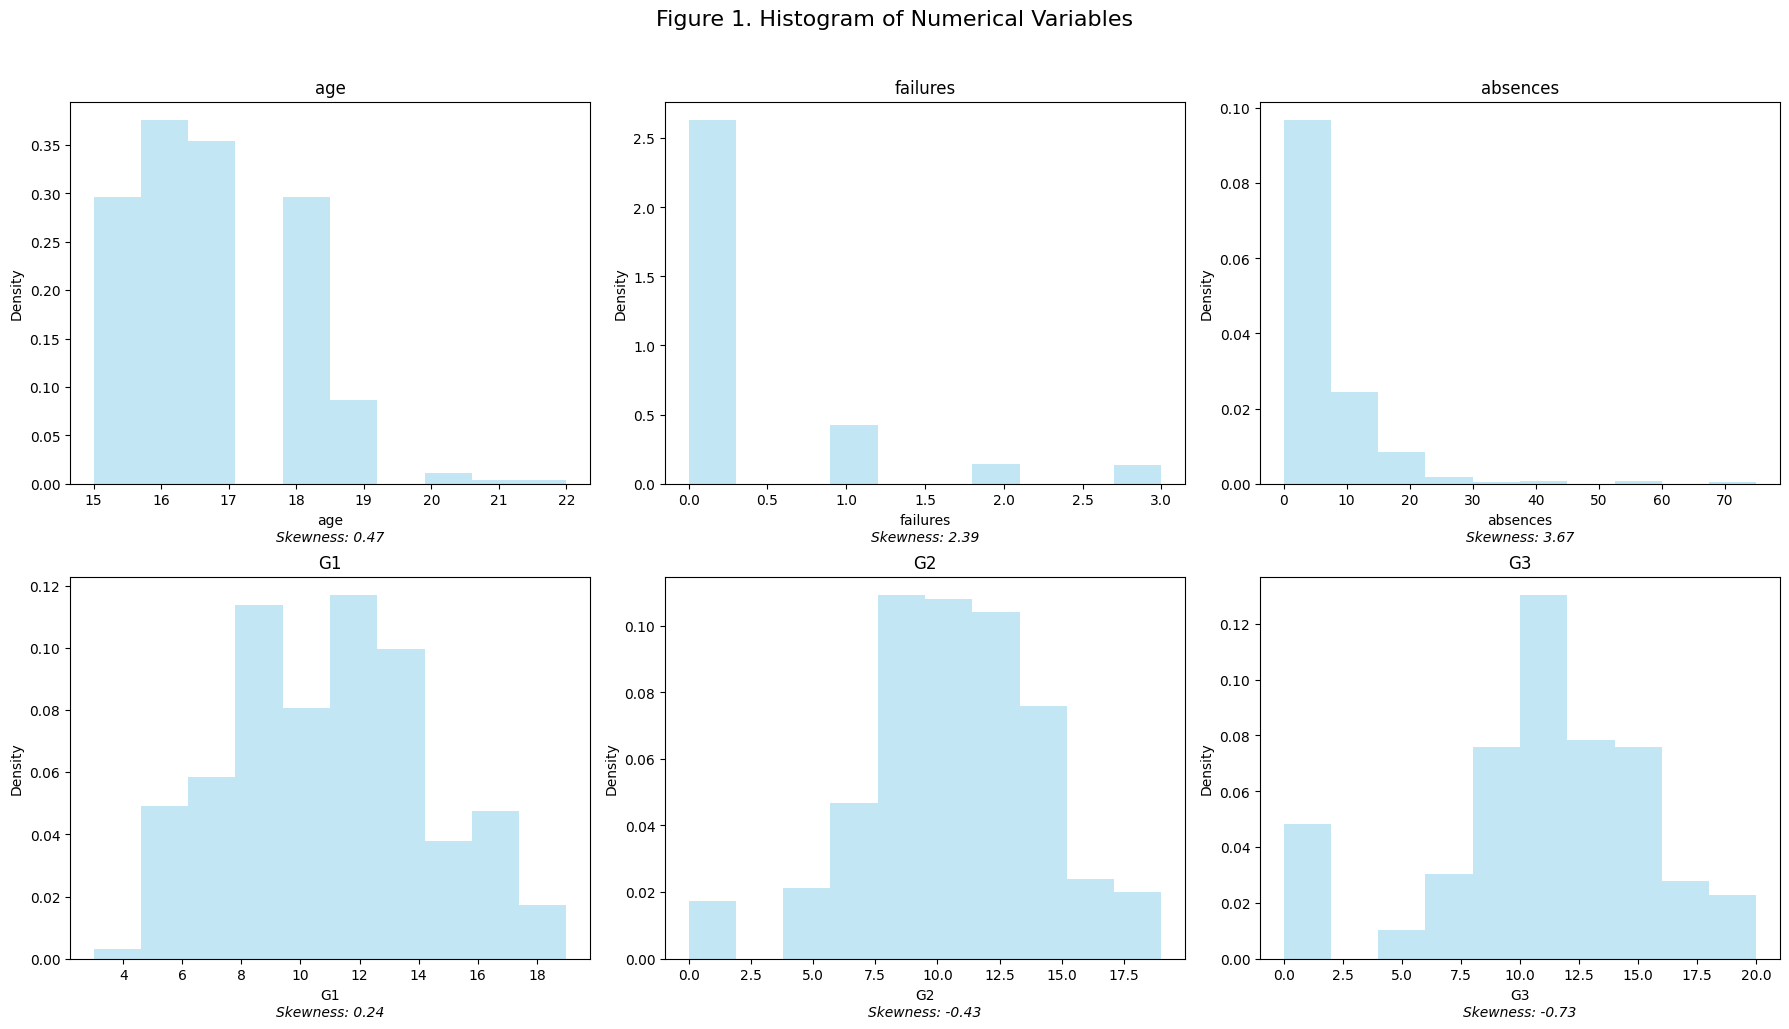

<Figure size 640x480 with 0 Axes>

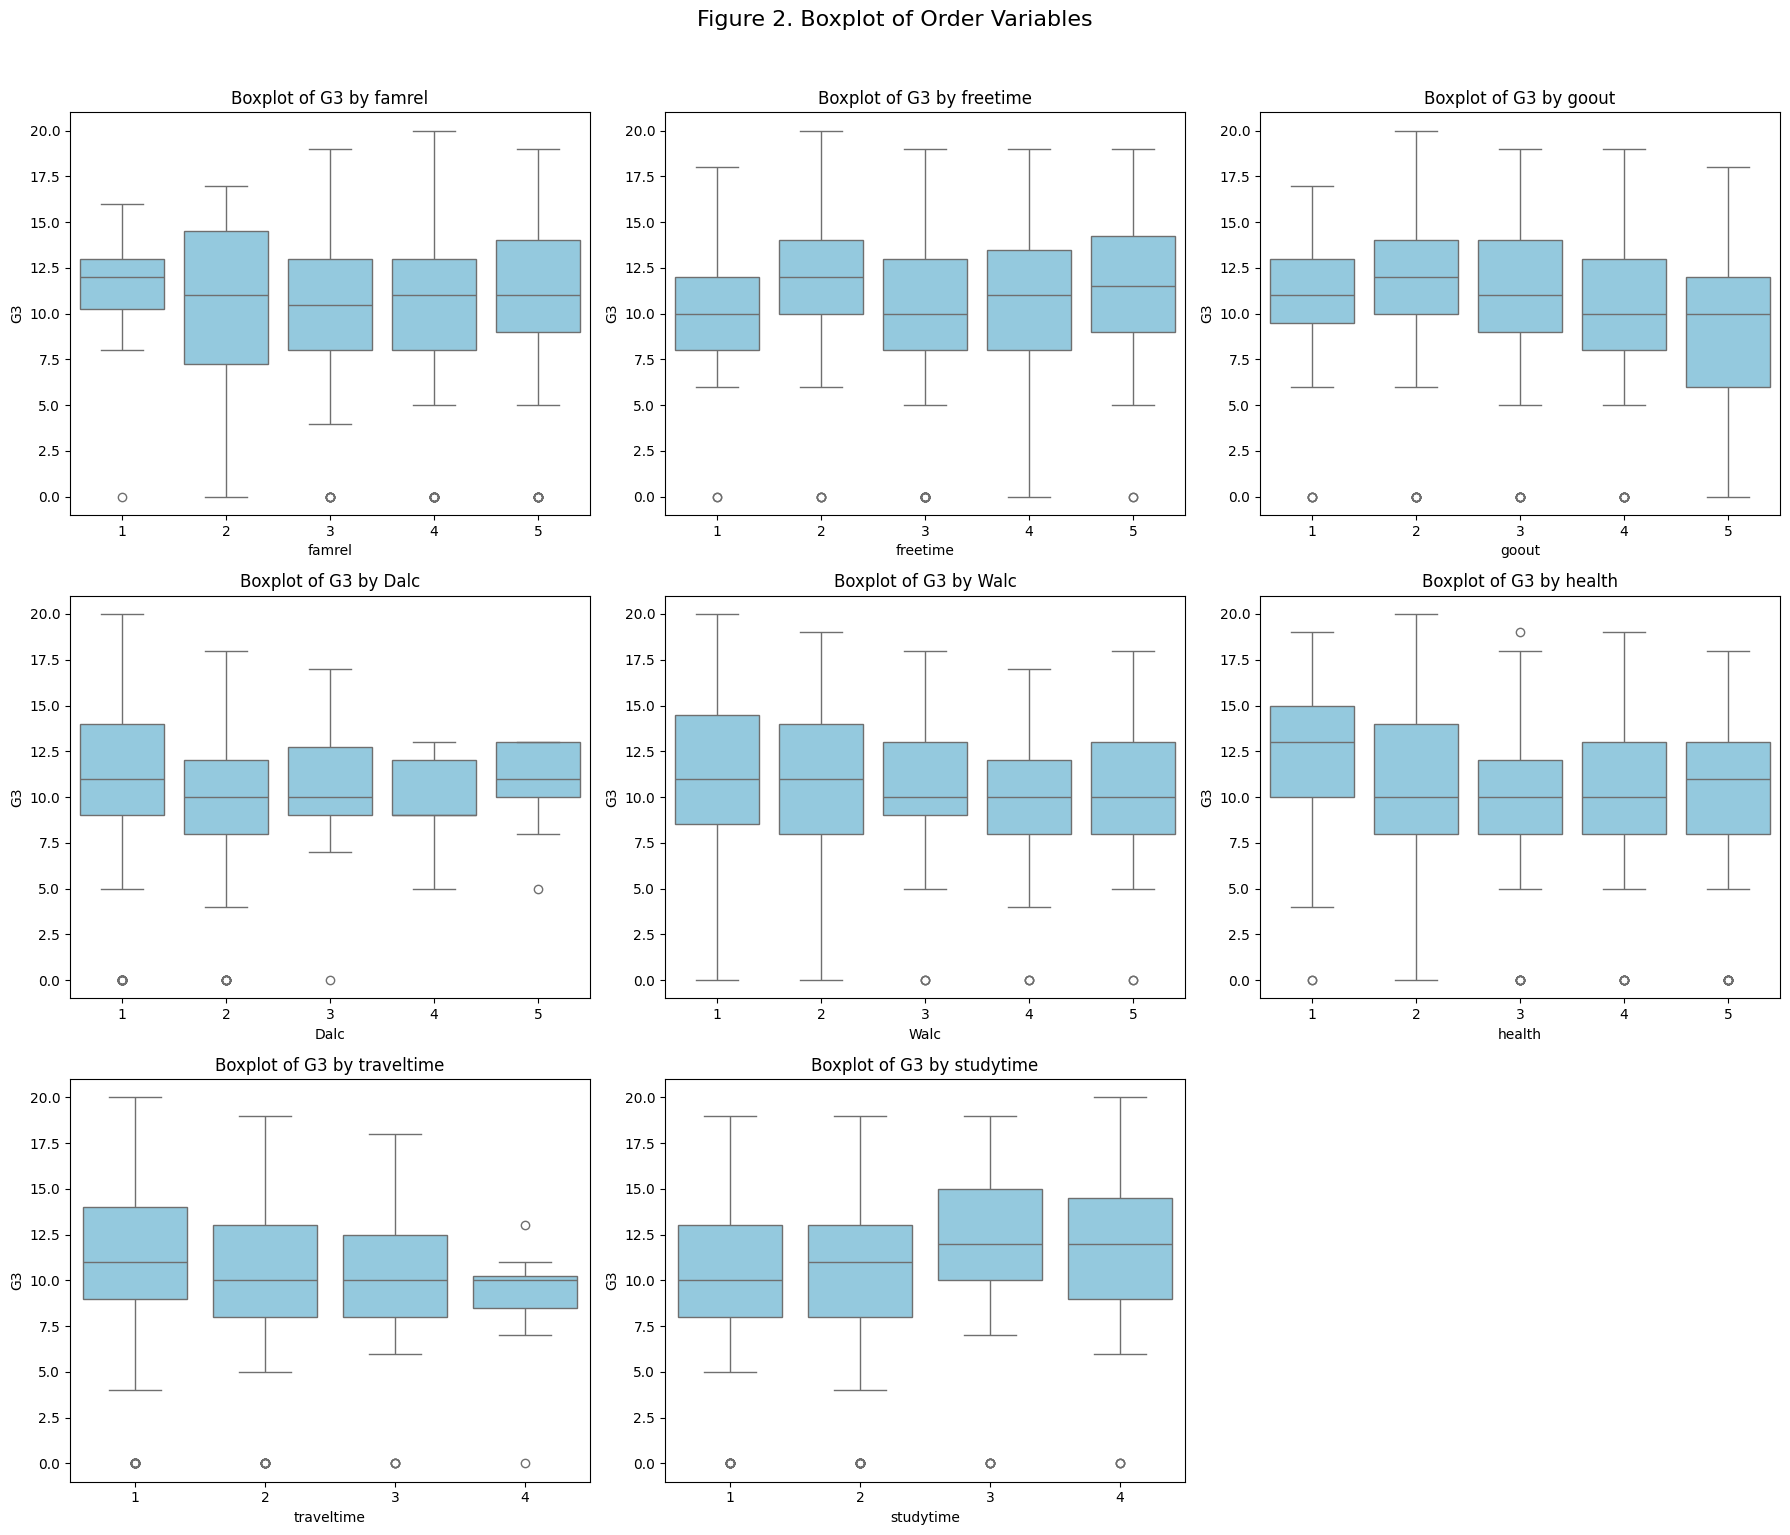


Tukey HSD test for sex:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
     F      M   0.9481 0.0399 0.0441 1.8521   True
--------------------------------------------------

Tukey HSD test for address:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
     R      U   1.1629 0.0356 0.0785 2.2473   True
--------------------------------------------------

Tukey HSD test for Medu:
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1   -4.322 0.4761 -11.5683 2.9243  False
     0      2  -3.2718 0.7217 -10.4429 3.8992  False
     0      3   -2.697 0.8413  -9.8721 4.4782  False
     0      4  -1.2366 0.9896  -8.3859 5.9127  False
     1      2   1.0502 0.6023  -0.948

<Figure size 640x480 with 0 Axes>

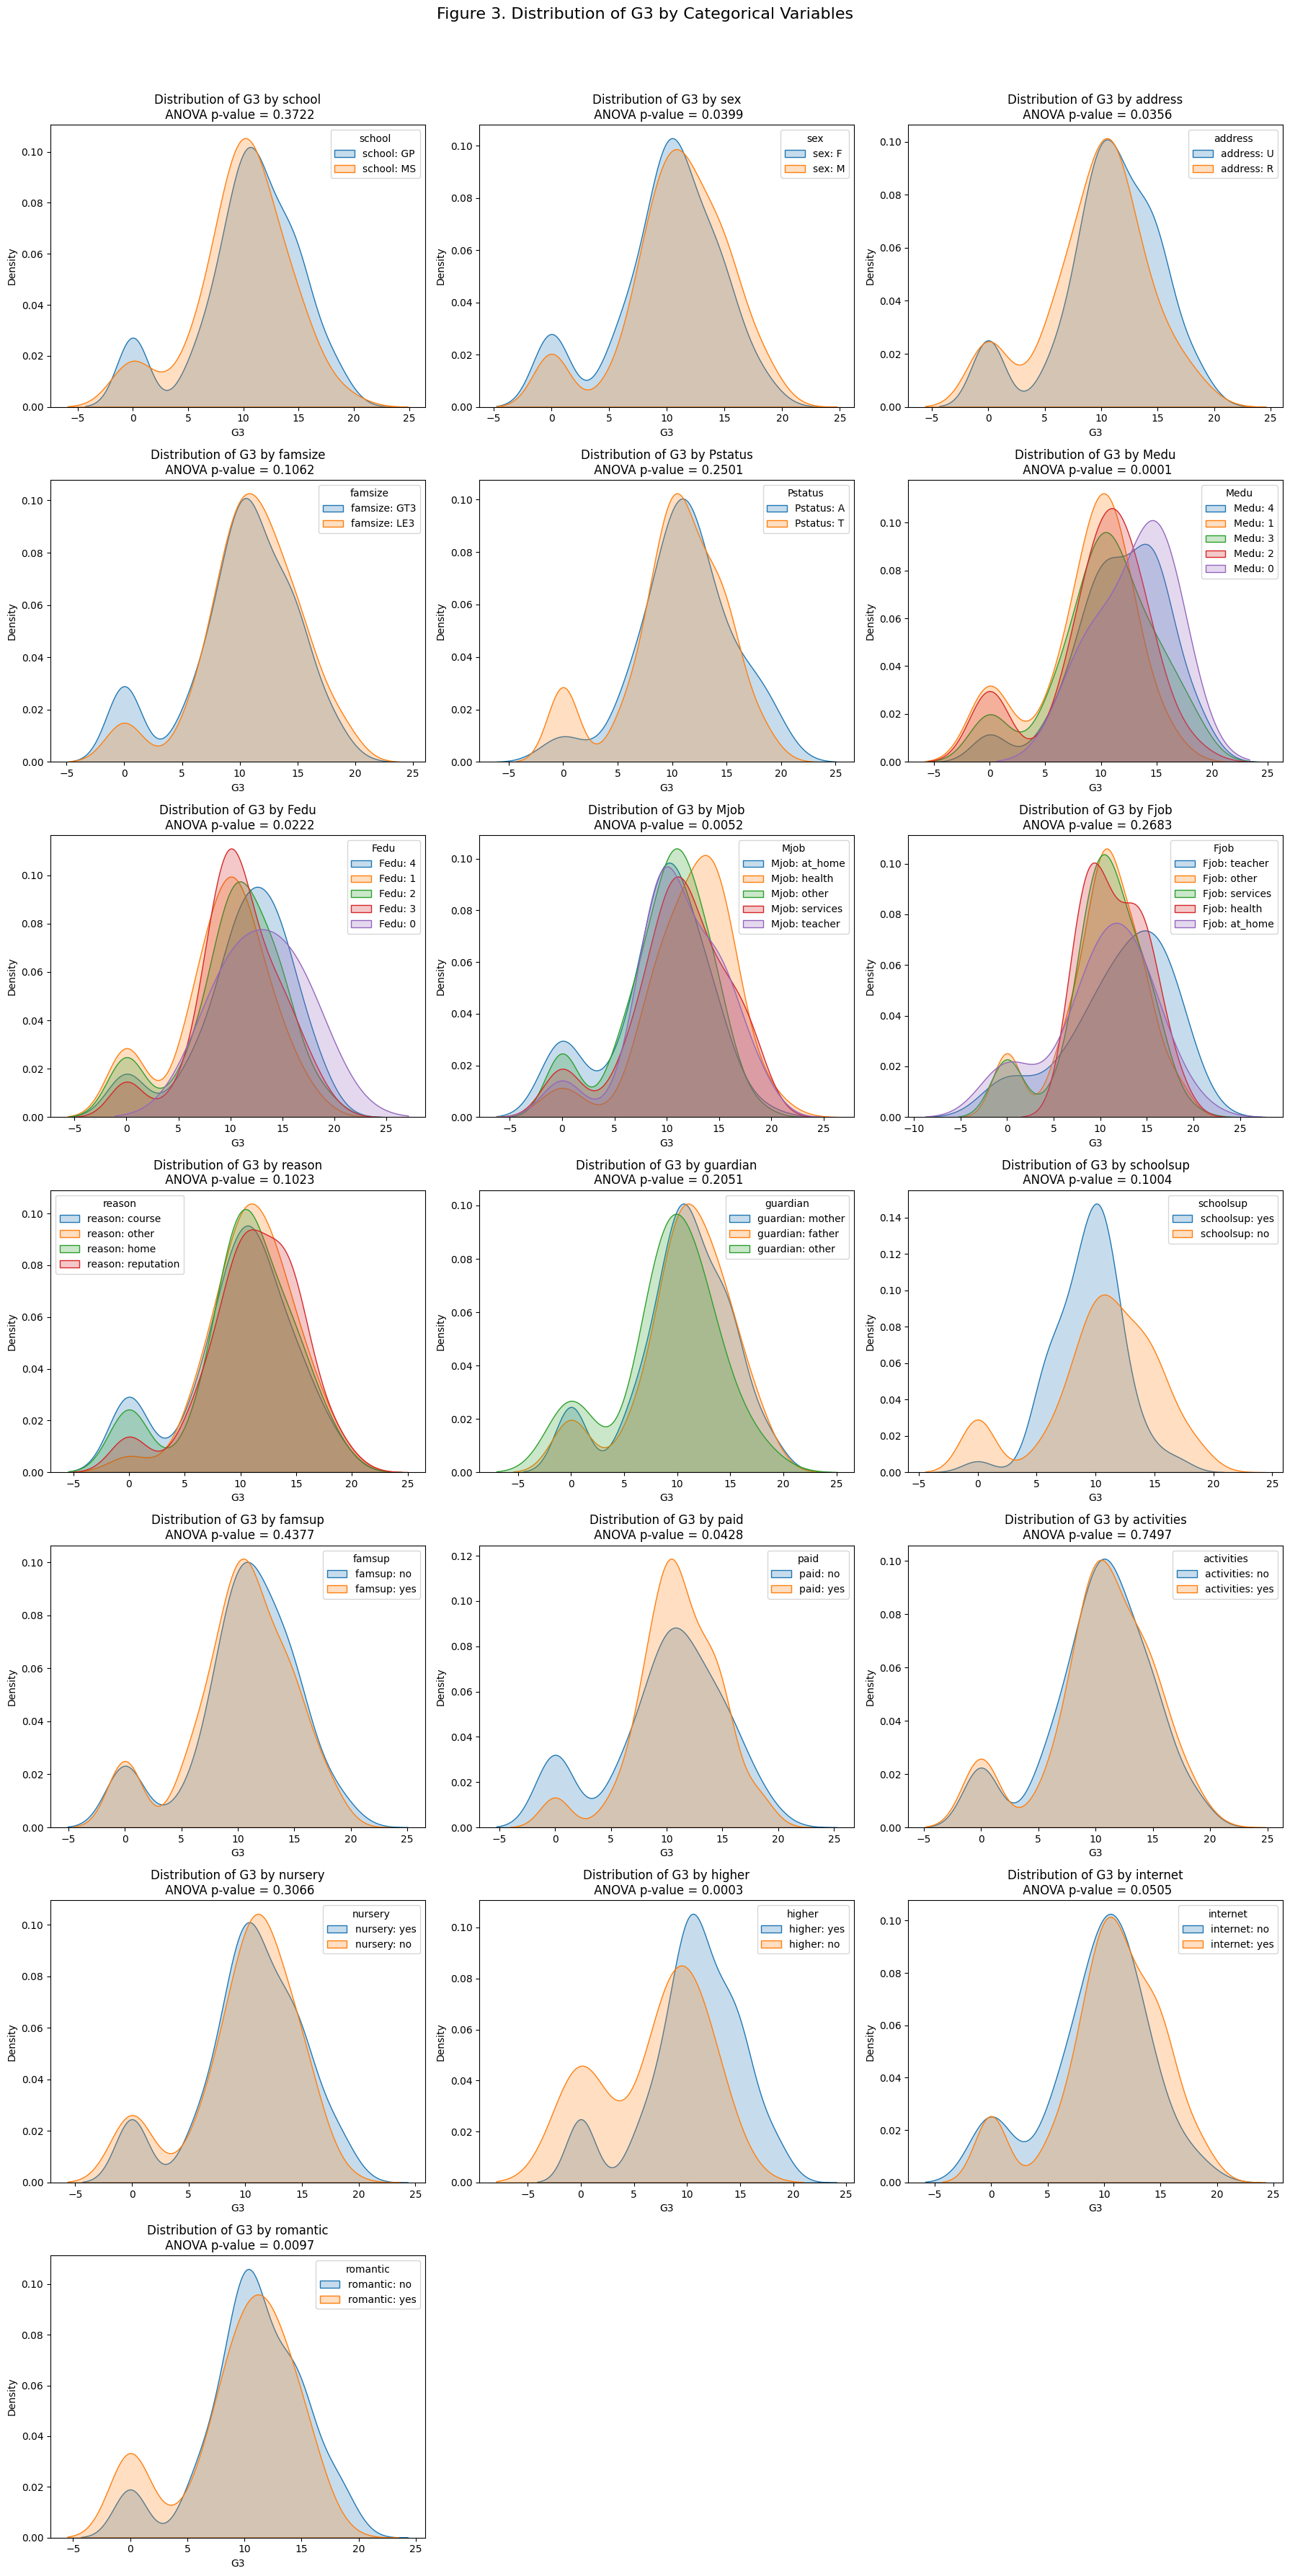

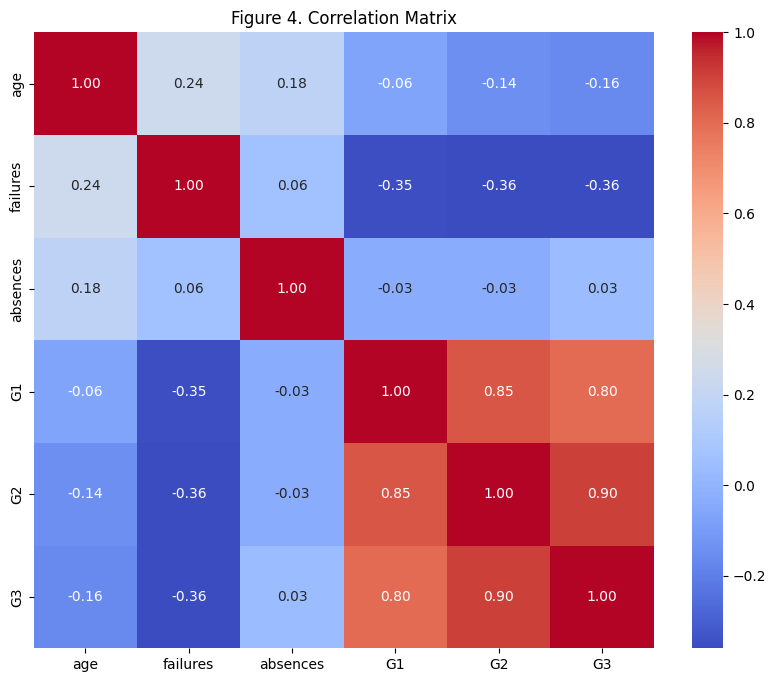

<Figure size 640x480 with 0 Axes>

In [ ]:
# read data
path = kagglehub.dataset_download("devansodariya/student-performance-data")
df = pd.read_csv(path+'/student_data.csv')

# summary the data information
data_prepare = prepare_data(df)
data_prepare.summary()

# visualizing the data
data_prepare.plot_historgam()
data_prepare.plot_boxplot()
data_prepare.plot_category_cols()
data_prepare.plot_cor_matrix()

# clearning nominal variable
df_c = data_prepare.clearning_nominal_variable()

# 2. Training Model

## 2.1 Data Split

In [ ]:
X = df_c.drop(columns=['G3'])
y = df_c['G3']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=42)

X_train, X_test = data_prepare.clearning_numerical_var(X_train, X_test)

print('==== base info ====')
print(f'X_train: {X_train.shape}')
print(f'y_train: {y_train.shape}')
print(f'X_test.: {X_test.shape}')
print(f'y_test.: {y_test.shape}')

print('==== G3 mean ====')
print(f'train: {y_train.mean():.2f}')
print(f'test: {y_test.mean():.2f}')

print('==== ANOVA test ====')
anova_train_test = f_oneway(y_train, y_test).pvalue
print(f'p-value: {anova_train_test:.2f}')


==== base info ====
X_train: (316, 47)
y_train: (316,)
X_test.: (79, 47)
y_test.: (79,)
==== G3 mean ====
train: 10.33
test: 10.77
==== ANOVA test ====
p-value: 0.44


## 2.2 Cross-Validation

In [ ]:
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
start_time = time.time()
gridsearch_best_models = {}


cv = KFold(n_splits = 5)
scoring = ['accuracy']
result= {'GridSearchCV':{}}

models = {
    "Linear Regression":LinearRegression(),
    "Random Forest Regressor": RandomForestRegressor(
        random_state = 5
    ),
    "MLPRegressor" :MLPRegressor(
        random_state = 5
    ),
    "XGBRegressor": XGBRegressor(
        random_state = 5
    )
}

# parameter set
grid_param_grids = {
    "Linear Regression":{
        'fit_intercept': [True, False],
        'n_jobs' : [1, -1]
        },
    "Random Forest Regressor":{
        'criterion': ["squared_error", "absolute_error"],
        "n_estimators": [25, 50, 75],
        "max_depth": [3, 5, 10],
        "min_samples_split": [5, 10]
    },
    "MLPRegressor":{
        "hidden_layer_sizes":[(100,50),(50,25)],
        "max_iter":[100]
    },
    "XGBRegressor":{
        "n_estimators": [25, 50, 75],
        "max_depth": [3, 5, 10],
        "learning_rate": [0.1, 0.2],
        "n_jobs": [1, -1] #-1
}
}

# training model
for model_name, model in models.items():

    grid_search = GridSearchCV(
        estimator = model,
        param_grid = grid_param_grids[model_name],
        return_train_score = True,
        scoring=mse_scorer,
        cv = cv).fit(X_train, y_train)

    result['GridSearchCV'][model_name] = (grid_search.cv_results_)
    gridsearch_best_models[model_name] = (grid_search.best_estimator_, grid_search.best_score_,
                              grid_search.best_params_)

    if model_name == "Linear Regression":
      best_params_lr = grid_search.best_params_

    elif model_name == "Random Forest Regressor":
      best_params_rf = grid_search.best_params_

    elif model_name == "MLPRegressor":
      best_params_mlp = grid_search.best_params_

    elif model_name == "XGBRegressor":
      best_params_xgb = grid_search.best_params_

# voting model
voting_model = VotingRegressor(
    estimators=[('lr', LinearRegression(**best_params_lr)),
                ('rf', RandomForestRegressor(**best_params_rf)),
                ('mlp', MLPRegressor(**best_params_mlp)),
                ('xgb', XGBRegressor(**best_params_xgb))]
)

grid_search = GridSearchCV(
    estimator = voting_model,
    return_train_score = True,
    scoring=mse_scorer,
    param_grid = {},
    cv = cv).fit(X_train, y_train)

result['GridSearchCV']['Votingmodel'] = (grid_search.cv_results_)
gridsearch_best_models['Votingmodel'] = (grid_search.best_estimator_, grid_search.best_score_,
                            grid_search.best_params_)

print(f'runing time: {time.time()-start_time} sec')
# show best models
print('=========================')
print(f'Number of folds : {k}')
print(f'runing time: {time.time()-start_time} sec')

for model_name, (best_model, best_score, best_params) in gridsearch_best_models.items():
    print(f'best model :{model_name}')
    print(f'best hyperparameters: {best_params}')
    print(f'=========================')

# model result
results_df = pd.DataFrame()
for search, models_data in result.items():
    for model_name, model_results in models_data.items():
        temp_df = pd.DataFrame(model_results)
        temp_df['search_method'] = search
        temp_df['model'] = model_name
        results_df = pd.concat([results_df, temp_df], ignore_index=True)

col_summary_df = pd.DataFrame()
columns = ['model','mean_train_score','mean_test_score','mean_fit_time']
for model_name in pd.unique(results_df['model']):
  temp_df = results_df[(results_df['model'] == model_name) & (results_df['rank_test_score'] == 1)][columns]
  if temp_df.shape[0]>1:
    temp_df = temp_df.sort_values(by='mean_fit_time', ascending=True).head(1)

  temp_df['mean_test_score'] = -temp_df['mean_test_score']
  temp_df['mean_train_score'] = -temp_df['mean_train_score']

  col_summary_df = pd.concat([col_summary_df, temp_df], ignore_index=True)

print('---Best Hyperparameters and Performance Metrics for Each Model---')
col_summary_df

runing time: 108.9038987159729 sec
Number of folds : 5
runing time: 108.90414333343506 sec
best model :Linear Regression
best hyperparameters: {'fit_intercept': True, 'n_jobs': 1}
best model :Random Forest Regressor
best hyperparameters: {'criterion': 'squared_error', 'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 75}
best model :MLPRegressor
best hyperparameters: {'hidden_layer_sizes': (100, 50), 'max_iter': 100}
best model :XGBRegressor
best hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 75, 'n_jobs': 1}
best model :Votingmodel
best hyperparameters: {}
---Best Hyperparameters and Performance Metrics for Each Model---


,model,mean_train_score,mean_test_score,mean_fit_time
0,Linear Regression,2.602623,3.740199,0.010639
1,Random Forest Regressor,0.479394,2.169784,0.244341
2,MLPRegressor,1.983370,4.005110,0.371665
3,XGBRegressor,0.536887,2.011030,0.054717
4,Votingmodel,1.101516,2.393672,1.268959


---

# 3. **Evaluate Model**

In [ ]:
model_name = "XGBRegressor"
best_model, best_score, best_params = gridsearch_best_models[model_name]
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mse)

print(f'MSE: {mse:.3f}')
print(f'RMSE: {rmse:.3f}')
print(f'R²: {r2_score(y_test, y_pred)*100:.2f} %')


MSE: 4.043
RMSE: 2.011
R²: 80.28 %
